# Imports

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import csv
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree

# Importing and Splitting data

In [2]:
file = pd.read_csv("audi.csv", quotechar='"', skipinitialspace=True)

modelEncoder = LabelEncoder()
modelEncoder.fit(file["model"])
file["model"] = modelEncoder.transform(file["model"])

transmissionEncoder = LabelEncoder()
transmissionEncoder.fit(file["transmission"])
file["transmission"] = transmissionEncoder.transform(file["transmission"])

fuelTypeEncoder = LabelEncoder()
fuelTypeEncoder.fit(file["fuelType"])
file["fuelType"] = fuelTypeEncoder.transform(file["fuelType"])

file = file.head(1000)
# X = file.drop(columns = ['price'])
# Y = file.price
# print(file)

X = file.drop(['price'], axis = 1).to_numpy(dtype = 'int')
# X = file[['year', 'mileage', 'tax', 'mpg', 'engineSize']].to_numpy(dtype = 'int')
Y = file['price'].values.reshape(-1,1)

print(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 601)

[[   0 2017    1 ...  150   55    1]
 [   5 2016    0 ...   20   64    2]
 [   0 2016    1 ...   30   55    1]
 ...
 [   5 2019    2 ...  150   37    3]
 [  10 2017    2 ...  150   34    3]
 [   4 2018    2 ...  150   35    3]]


# Using Scikit-Learn

In [27]:
myTree = DecisionTreeRegressor(random_state = 601, max_depth = 3)
myTree.fit(X_train, Y_train)
print("R Squared: ", myTree.score(X_test, Y_test))

R Squared:  0.6914297444588275


# Visualising Decsion Tree:

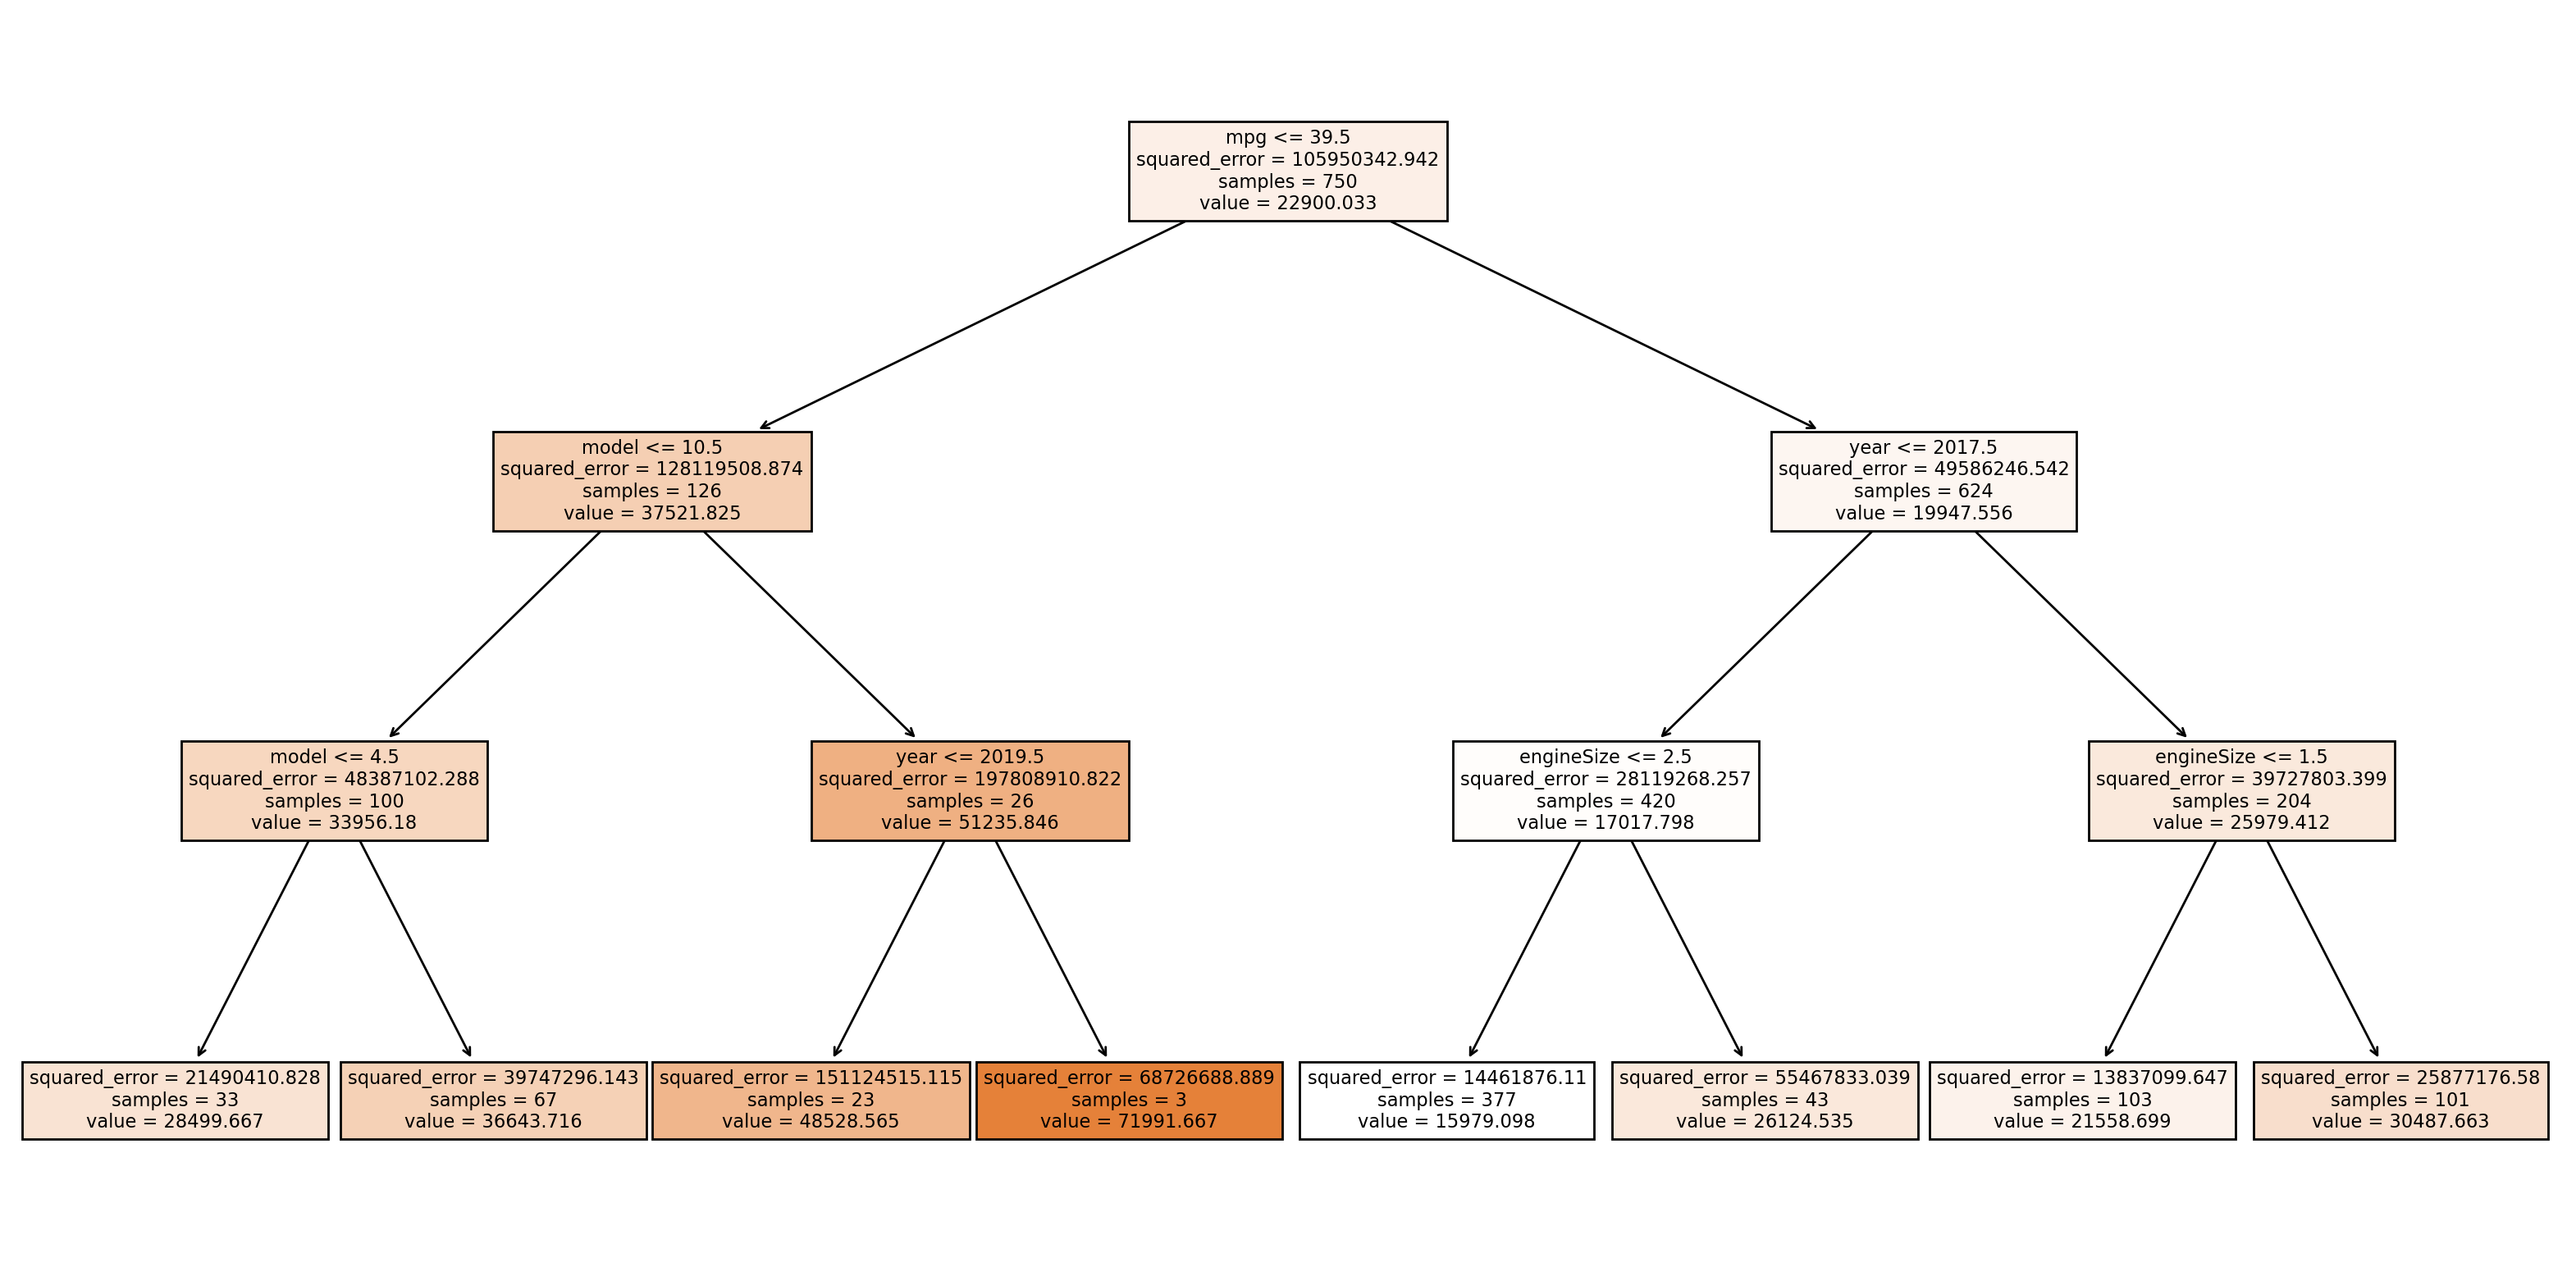

In [53]:
plt.figure(figsize=(20, 10), dpi = 200)
plot_tree(myTree, feature_names = X.columns, filled=True);

# RMSE

In [6]:
def rmse(h, y):
  return sqrt(mean_squared_error(h, y))

# Node Class

In [7]:
class Node():
    def __init__(self, feature = None, threshold = None, left = None, right = None, gain = None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.gain = gain
        self.value = value #leaf

# Decision Tree Regression Class

In [8]:
class DTRegressor():
    def __init__(self, minSamples, maxDepth):
        self.root = None
        self.minSamples = minSamples
        self.maxDepth = maxDepth
        
#     def entropy(self, y): #need to change method
#         entropy = 0
        
#         labels = np.unique(y)
#         # loop over each unique value
#         for label in labels:
#             # find elements in y that are equal to that label
#             label_examples = y[y == label]
#             # get ratio of the label
#             pl = len(label_examples) / len(y)
#             # calculate entropy
#             entropy += -pl * np.log2(pl)
#         return entropy
        
    def infoGain(self, parent, leftNode, rightNode): #need to checkkk
#         print("HERE 5")
        leftWeight = len(leftNode) / len(parent)
        rightWeight = len(rightNode) / len(parent)
        
        information_gain = np.var(parent) - (leftWeight * np.var(leftNode) + rightWeight * np.var(rightNode))


#         parent_entropy = self.entropy(parent)
#         entropy_left, entropy_right = self.entropy(leftNode), self.entropy(rightNode)
#         # calculate weighted entropy 
#         weighted_entropy = leftWeight * entropy_left + rightWeight * entropy_right
#         # calculate information gain 
#         information_gain = parent_entropy - weighted_entropy
        return information_gain
        
    def splitTree(self, dataset, feature, threshold):
#         print("HERE 4")
        leftBranch = []
        rightBranch = []
        for i in dataset:
            if i[feature] <= threshold:
                leftBranch.append(i)
            else:
                rightBranch.append(i)
        rightBranch = np.array(rightBranch)
        leftBranch = np.array(leftBranch)
        return leftBranch, rightBranch
        
    def bestSplit(self, dataset, X):
#         print("HERE 3")
        bestSplitt = {} 
        maxGain = -1
        for feature in range(X.shape[1]): 
            featureValues = dataset[:, feature] #current feature selected
            thresholds = np.unique(featureValues)
            for j in thresholds: #threshold = j
                # get current split
                leftSide, rightSide = self.splitTree(dataset, feature, j) #splits tree into 2 branches
                if (len(leftSide) > 0 and len(rightSide) > 0 ):
                    parent = dataset[:, -1]
                    leftNode = leftSide[:, -1]
                    rightNode = rightSide[:, -1]

                    currentGain = self.infoGain(parent, leftNode, rightNode) 
                    if currentGain > maxGain:
                        
                        bestSplitt["feature"] = feature
                        bestSplitt["thresholds"] = j
                        bestSplitt["leftSide"] = leftSide
                        bestSplitt["rightSide"] = rightSide
                        bestSplitt["gain"] = currentGain
                        maxGain = currentGain
                
        return bestSplitt
   
        
    def treeBuild(self, dataset, currentDepth = 0):
#         print("HERE 2")
        X = dataset[:,:-1]
        Y = dataset[:,-1] #Split training into features and labels
        samplesNumb = X.shape[0]
        featuresNumb = X.shape[1]
        
        #iterates until this condition is met
        if X.shape[0] >= self.minSamples and currentDepth <= self.maxDepth:
#             bestSplit = self.bestSplit(dataset, samplesNumb, featuresNumb)
            bestSplit = self.bestSplit(dataset, X)
            
            if bestSplit["gain"] > 0:
                leftTree = self.treeBuild(bestSplit["leftSide"], currentDepth + 1)
                rightTree = self.treeBuild(bestSplit["rightSide"], currentDepth + 1)
                decision = Node(bestSplit["feature"], bestSplit["thresholds"], leftTree, rightTree, bestSplit["gain"])
                
                return decision
            
        leafValue = np.mean(Y) #calculates mean of leaf nodes
        val = Node(value = leafValue)
        return val
    
    def predictionLoop(self, testRow, root):
        if root.value != None: #not empty
            return root.value
        
        featureVal = testRow[root.feature] #PROBLEM HERE "list index out of range"
#         print(featureVal)
        if featureVal <= root.threshold:
            return self.predictionLoop(testRow, root.left)
        else:
            return self.predictionLoop(testRow, root.right)
        
   
    def predict(self, xTest):
        predictions = []
        for row in xTest:
#             print(row)
            predictions.append(self.predictionLoop(row, self.root)) 
        return predictions

        
        
    def fit(self, X, Y):
#         print("HERE 1")
        dataset = np.concatenate((X, Y), axis=1) #Joins training data back together
        self.root = self.treeBuild(dataset)

# Training the algorithm

In [12]:
myTree = DTRegressor(3, 3)  
myTree.fit(X_train, Y_train) #trains the model using the training set

# Evaluation

In [17]:
def evaluation(train, test, yTrain, yTest):    
    y_pred = myTree.predict(X_test)
    error = rmse(yTest, y_pred) 
    print('The RMSE value is:', error)
    for i in range(len(y_pred)):
        print("\nOriginal value:", yTest[i], "vs the predicted value:", y_pred[i])
        print("The difference is:", yTest[i] - y_pred[i])
evaluation(X_train, X_test, Y_train, Y_test)

The RMSE value is: 5528.149202131562

Original value: [18498] vs the predicted value: 17614.6
The difference is: [883.4]

Original value: [22995] vs the predicted value: 17614.6
The difference is: [5380.4]

Original value: [12495] vs the predicted value: 34189.666666666664
The difference is: [-21694.66666667]

Original value: [14500] vs the predicted value: 13272.457746478873
The difference is: [1227.54225352]

Original value: [24995] vs the predicted value: 20879.25806451613
The difference is: [4115.74193548]

Original value: [10200] vs the predicted value: 17614.6
The difference is: [-7414.6]

Original value: [21995] vs the predicted value: 20879.25806451613
The difference is: [1115.74193548]

Original value: [16800] vs the predicted value: 17614.6
The difference is: [-814.6]

Original value: [12798] vs the predicted value: 13272.457746478873
The difference is: [-474.45774648]

Original value: [20498] vs the predicted value: 54140.307692307695
The difference is: [-33642.30769231]

Or

# User Input Predictions

In [11]:
inputPred = []
entries = []

# print(list(modelEncoder.classes_))
inputPred.append((modelEncoder.transform([input("What Model is your car? ")]))[0])
inputPred.append(int(input("What year is your car? ")))
inputPred.append((transmissionEncoder.transform([input("What transmission is your car? ")]))[0])
inputPred.append(int(input("How much mileage does your car have? ")))
inputPred.append((fuelTypeEncoder.transform([input("What's your car fuel type? ")]))[0])
inputPred.append(int(input("How much is your cars tax? ")))
inputPred.append(float(input("What's MPG of your car? ")))
inputPred.append(float(input("What the engine size of your car? ")))
entries.append(inputPred)
# inputPred = scaler.transform([inputPred])

import time
print("\n ***Predicting***")
start = time.time()
y_pred = myTree.predict([inputPred])
# {0:.2f}'.format()
print("\n Predicted price for your car is: £", y_pred[0])

print("\n ***Predicted in", time.time() - start,"seconds***")
# RS6,2016,Semi-Auto,49050,Petrol,325,29.4,4.0 -- Price is £44985

What Model is your car? RS6
What year is your car? 2016
What transmission is your car? Semi-Auto
How much mileage does your car have? 49050
What's your car fuel type? Petrol
How much is your cars tax? 325
What's MPG of your car? 29.4
What the engine size of your car? 4

 ***Predicting***

 Predicted price for your car is: £ 41233.3

 ***Predicted in 0.0009970664978027344 seconds***
